##Problem

Caregiver records duration for an infant's sleep over a period of time. How do we express if there was an anomaly in sleeping patterns for the child

##Formal Expression of Problem

How to estimate expected duration of sleep at time t(i) if we know the sleep pattern at time t(i-1), t(i-2)...

##Data

* Our data is events data that parents record through different sources such as alexa or messenger
* Nature of data is "time series" as it continues to be recorded, over discrete intervals
* Data which is in JSON format is converted into CSV for purpose of model
* Each row records [Event Time, Metadata Duration of Sleep]

* For purpose of our inital model our hypothesis is that prior duration of sleep is relevant in decide how much would we sleep next. While sleep time is important, we can ignore it for now since events a recorded periodically.

```
"_id__$oid","duration","event_type","event_time","request_id","source_id","child_id","caregiver_id","metadata__duration"
===================================================

"58f861d9ddd9ff0001a06ac3","None","sleep","1492686311","1234","amzn1.ask.account.redacted","58a40a921d90110001fd52ba","58a40a921d90110001fd52b9","6"

"58f861d9ddd9ff0001a06ac4","None","sleep","1492702596","1234","amzn1.ask.account.redacted","58a40a921d90110001fd52ba","58a40a921d90110001fd52b9","7"

```

##Approach
* Given we are dealing with sequential data, a common practice is to use RNN (Recurrent Neural Network). In that LSTM is most successfully used
* This is because LSTM hold good long term memories, so prediction of nth sample can be influenced by input given many steps before.

###LSTM synopsis
* Instead of classical neuron model, LSTM holds memory blocks + gates
* Gate use a sigmoid activation function to determine block should be activated. Sigmoid function provides a range of continious values between 0 & 1. This is useful so output changes slowly compared to input
* If it activates the gate it changes the state for the bock

##Tools

* Keras - py library built on top of tensorflow. Its an interface, which helps easy setup of neural networks
* Anaconda for general tooling
* Jupyter notebook for tracking. I am using docker image gw000/keras-full to run it locally

In [62]:
import numpy
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
import pandas
import matplotlib.pyplot as plt

Loading inital data

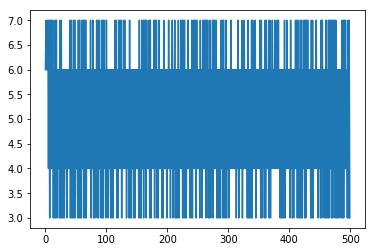

In [63]:

data = pandas.read_csv('events_db.csv', usecols=[8], engine='python')
dataset = data # retaining for later reuse, after we transform dataset
plt.plot(data)
plt.show()


In [64]:
print len(data)
print numpy.mean(data)

500
metadata__duration    4.982
dtype: float64


Data here is for ~500 sleep events, with most duration in between 4-6 hrs at different intervals 

In [65]:
numpy.random.seed(7)
dataset = dataset.values
dataset =  dataset.astype('float32')
print dataset[0:5]

[[ 6.]
 [ 7.]
 [ 6.]
 [ 6.]
 [ 7.]]


We will normalize the data in 0-1 range as its best practice when using sigmoid function

In [66]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
print dataset[0:5]

[[ 0.75]
 [ 1.  ]
 [ 0.75]
 [ 0.75]
 [ 1.  ]]


We now will create the dataset. What we are essentially doing here is listing out different Sleep Duration in "Group of 3"

So if our sleep durations are [1, 2, 3, 5, 6]
We structure it as
```
 [1, 2, 3
  2, 3, 5
  3, 5, 6]
```
This enables us to look back last 3 sleep durations 

In [67]:
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

# create training & test dataset
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
print "TrainX dataset sample"
print trainX[0:5]
print "TrainY dataset sample"
print trainY[0:5]

# get data in shape for fiting model
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))

TrainX dataset sample
[[ 0.75  1.    0.75]
 [ 1.    0.75  0.75]
 [ 0.75  0.75  1.  ]
 [ 0.75  1.    0.25]
 [ 1.    0.25  1.  ]]
TrainY dataset sample
[ 0.75  1.    0.25  1.    0.  ]


Now we come to actually applying a RNN and fitting it. In here epoch means how many times do we want to do a complete pass over the dataset

Batch here is subset size of our training data

In [68]:
model = Sequential()
model.add(LSTM(4, input_shape=(look_back, 1)))
model.add(Dense(1)) # meant for output layer
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
1s - loss: 0.2461
Epoch 2/100
0s - loss: 0.1731
Epoch 3/100
0s - loss: 0.1176
Epoch 4/100
0s - loss: 0.0302
Epoch 5/100
0s - loss: 0.0212
Epoch 6/100
0s - loss: 0.0209
Epoch 7/100
0s - loss: 0.0208
Epoch 8/100
0s - loss: 0.0205
Epoch 9/100
0s - loss: 0.0202
Epoch 10/100
0s - loss: 0.0202
Epoch 11/100
0s - loss: 0.0202
Epoch 12/100
0s - loss: 0.0199
Epoch 13/100
0s - loss: 0.0191
Epoch 14/100
1s - loss: 0.0199
Epoch 15/100
0s - loss: 0.0197
Epoch 16/100
0s - loss: 0.0194
Epoch 17/100
0s - loss: 0.0196
Epoch 18/100
0s - loss: 0.0192
Epoch 19/100
0s - loss: 0.0191
Epoch 20/100
0s - loss: 0.0190
Epoch 21/100
1s - loss: 0.0191
Epoch 22/100
1s - loss: 0.0189
Epoch 23/100
0s - loss: 0.0188
Epoch 24/100
0s - loss: 0.0188
Epoch 25/100
0s - loss: 0.0183
Epoch 26/100
0s - loss: 0.0189
Epoch 27/100
0s - loss: 0.0185
Epoch 28/100
0s - loss: 0.0186
Epoch 29/100
0s - loss: 0.0184
Epoch 30/100
0s - loss: 0.0182
Epoch 31/100
0s - loss: 0.0183
Epoch 32/100
0s - loss: 0.0182
Epoch 33/100
0s -

Now that we have a model in place. We can try to make predictions. One thing to observe is that our loss lowered at higher pace earlier, before becoming consistent.

In [69]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))

print('Test RMSE Score: %.3f RMSE' % (testScore))
print('Train RMSE Score: %.3f RMSE' % (trainScore))

Test RMSE Score: 0.503 RMSE
Train RMSE Score: 0.513 RMSE


We can now look at our baseline & prediction

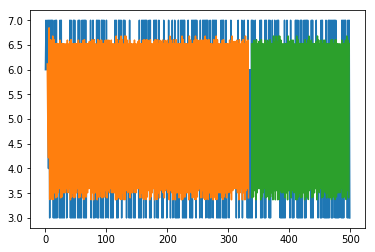

5.0267


In [71]:
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

If we compare this graph with earlier one in [63] we can observe that from a test dataset perspective we are able to gauge most the estimates but are unable to fit further. This probably needs further more tuning. However if we get the mean for training & test data we are close to mean of over all dataset.

In [73]:
print "Mean for training prediction: %s" %(numpy.mean(trainPredict))
print "Mean for test prediction: %s" %(numpy.mean(testPredict))

Mean for training prediction: 5.01911
Mean for test prediction: 5.0267
